#final project#

# install and load libraries
# change dataframe display

In [1]:
# installing py-translate for text translation(here, from russian to english)
!pip install py-translate

     |████████████████████████████████| 61 kB 3.1 MB/s 


In [2]:
# installing jellyfish package to compute levenshtein distance
!pip install jellyfish

     |████████████████████████████████| 90 kB 3.6 MB/s 


In [175]:
# loading the required libraries

import numpy as np
import pandas as pd 
import scipy.sparse
import gc
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import jellyfish
from tqdm import tqdm_notebook
from itertools import product

from string import punctuation
from translate import translator
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error



# Downcast dtypes from 64 to 32 bit to save memory
# by creating a downcast function

def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df



# setting the dataframes display

pd.set_option('display.max_rows', 600)
pd.set_option('display.max_columns', 50)

# Load data subset

In [176]:
sales = pd.read_csv("sales_train.csv",parse_dates=['date'])
item_cats = pd.read_csv('item_categories.csv')
items = pd.read_csv('items.csv')
shops = pd.read_csv('shops.csv')
test = pd.read_csv('test.csv')

## EDA

### sales table

In [177]:
# checking sales shape
print(f'sales dataframe shape: {sales.shape}')

# looking for missing values
print(sales.isna().sum())

sales.head()

sales dataframe shape: (2935849, 6)
date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-02-01,0,59,22154,999.00,1.0
1,2013-03-01,0,25,2552,899.00,1.0
2,2013-05-01,0,25,2552,899.00,-1.0
3,2013-06-01,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0


In [178]:
sales.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


remarks from those statistics :
- there is at least one outlier for item_price
- there is at least one negative item_price
- there is at least one outlier for item_cnt_day

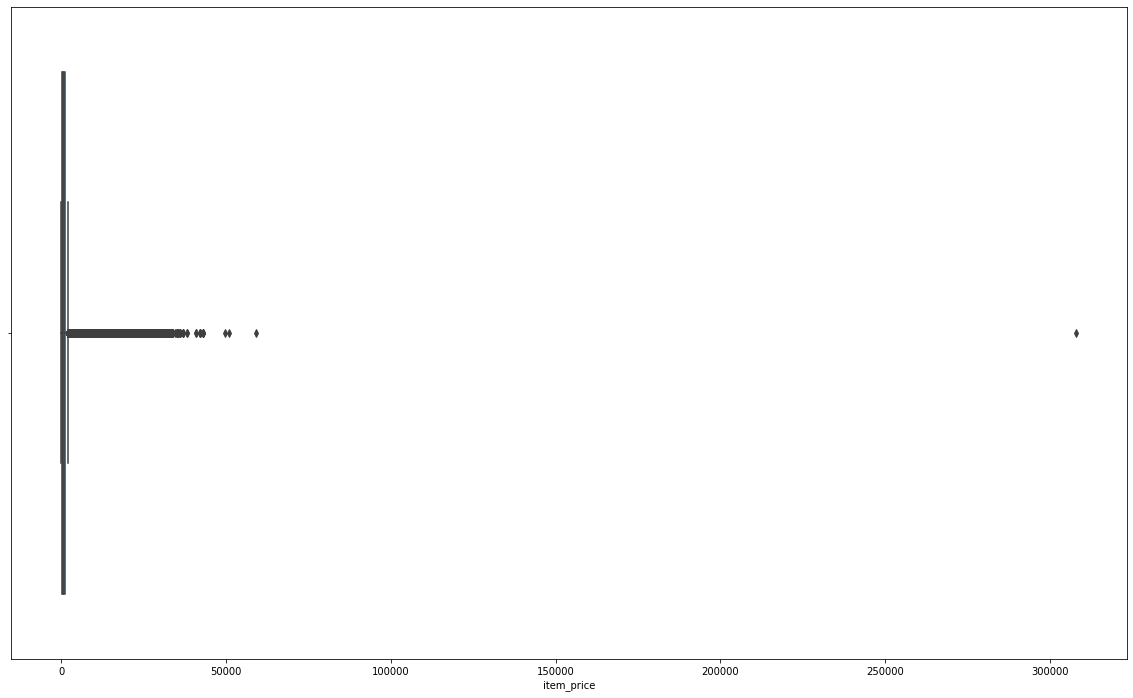

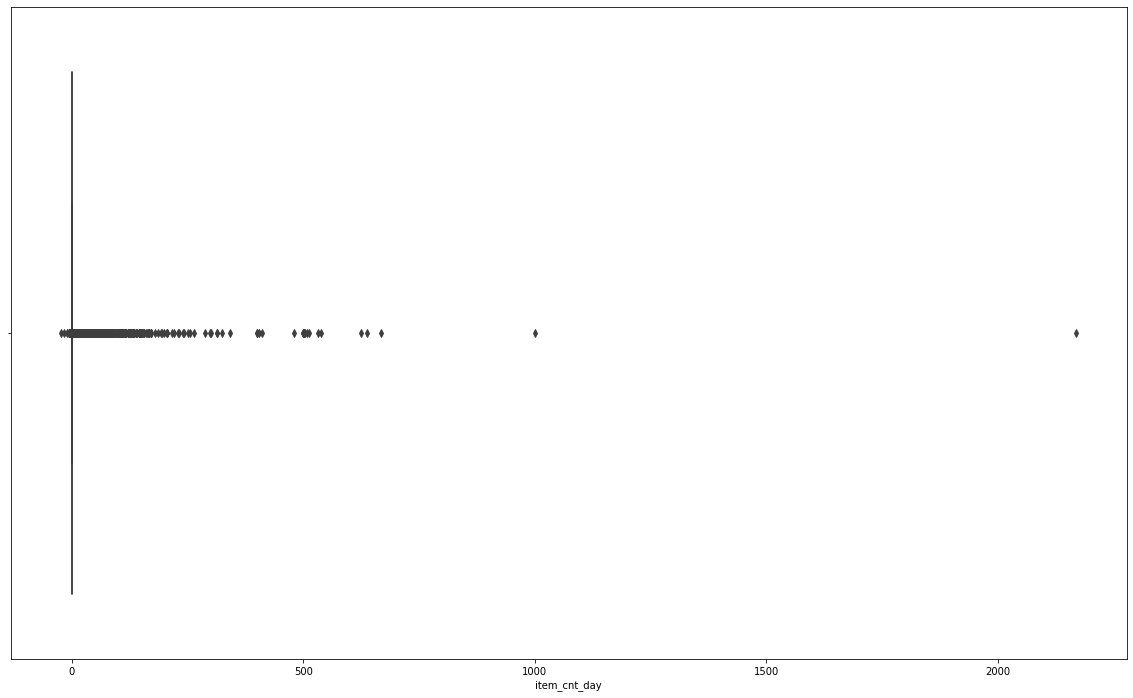

In [179]:
# box plot to visualize oultiers
for column in ['item_price','item_cnt_day']:
  plt.figure(figsize=(20,12))
  sns.boxplot(x=sales[column],data=sales)
  plt.show()

item_price outliers:

In [180]:
# according to the correponding box plot let's check for item_price > 45000
sales[sales['item_price']>45000]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
885138,2013-09-17,8,12,11365,59200.0,1.0
1163158,2013-12-13,11,12,6066,307980.0,1.0
1488135,2014-03-20,14,25,13199,50999.0,1.0
2327159,2015-01-29,24,12,7241,49782.0,1.0


In [181]:
sales[sales['item_price']>45000]['item_id']

885138     11365
1163158     6066
1488135    13199
2327159     7241
Name: item_id, dtype: int64

In [182]:
# let's check if there are other records for these items with different prices
item_ids_outliers = sales[sales['item_price']>45000]['item_id']


display(sales.loc[sales['item_id'].isin(item_ids_outliers), :].groupby('item_id').agg({'item_price':'count'}))
display(sales.loc[sales['item_id'].isin(item_ids_outliers), :].groupby('item_id').agg({'item_price':'mean'}))
display(sales.loc[sales['item_id'].isin(item_ids_outliers), :].groupby('item_id').agg({'item_price':'median'}))

,item_price
item_id,
6066,1
7241,1
11365,242
13199,1


,item_price
item_id,
6066,307980.000000
7241,49782.000000
11365,1887.565416
13199,50999.000000


,item_price
item_id,
6066,307980.00
7241,49782.00
11365,1203.75
13199,50999.00


we can see that we have only one record for items 6066, 7241 and 13199
but  242 records for item 11365 with an item_price mean of 1887.56 and a median of 1203.75.
let's see how many records we have for these items in test set 


In [183]:
# number of records for these items in test set
for item in item_ids_outliers:
  print(f'number of record for item_id {item} in test set is ',len(test[test.item_id==item]))

number of record for item_id 11365 in test set is  42
number of record for item_id 6066 in test set is  0
number of record for item_id 13199 in test set is  0
number of record for item_id 7241 in test set is  0


In [184]:
# dropping the outlier items that have only one record in sales and none in test
sales = sales[~sales.item_id.isin([6066,7241,13199])] 

In [185]:
# for the item 11365, since we have an outlier for one of its records we gonna replace it with the median 
sales.iloc[885138,4]=sales[sales.item_id==11365]['item_price'].median()

In [186]:
del item_ids_outliers
gc.collect()

5702

negative item_price:
- we have also an item_price equal to -1, let's check for all item_price<0

In [187]:
sales[sales['item_price']<0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,2013-05-15,4,32,2973,-1.0,1.0


In [188]:
# let's see if we don't have another record with the corresponding item to check for the right price (for the same period and same shop)
sales[(sales['item_id']==2973) & (sales['shop_id']==32) & (sales['date_block_num']==4)]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484682,2013-05-23,4,32,2973,1249.0,1.0
484683,2013-05-15,4,32,2973,-1.0,1.0
484684,2013-06-05,4,32,2973,2499.0,1.0


hard to say if it's 1249 or 2499 which is by the way the double, we are going to fill this value with the item_price mean

In [189]:
sales.iloc[484683,4] = sales[(sales['item_id']==2973) & (sales['shop_id']==32) & (sales['date_block_num']==4)]['item_price'].mean()

item_cnt_day outlier:
- let's check for item_cnt_day maximum and see what is the corresponding item

In [190]:
sales[sales['item_cnt_day']>=1000]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2326930,2015-01-15,24,12,20949,4.000000,1000.0
2909818,2015-10-28,33,12,11373,0.908714,2169.0


In [191]:
# now we can check the item_cnt_day for all the records with the same item_id
item_cnt_day_outliers_ids = sales[sales['item_cnt_day']>=1000]['item_id']
for item in item_cnt_day_outliers_ids:
  print(item)
  display(sales[sales['item_id']==item]['item_cnt_day'].describe())

20949


count    31340.000000
mean         5.987301
std         11.497655
min        -16.000000
25%          2.000000
50%          3.000000
75%          7.000000
max       1000.000000
Name: item_cnt_day, dtype: float64

11373


count     464.000000
mean       14.144397
std       104.604937
min         1.000000
25%         2.000000
50%         4.000000
75%         8.000000
max      2169.000000
Name: item_cnt_day, dtype: float64

- for item_id 20949, mean is 5.99 and median is 3 so 1000 doesn't seem to be a correct recording so we are going to drop this row

- for item_id 11373, mean is 14 and median is 4 so 2169 doesn't seem to be a correct recording so we are going to drop this row

In [192]:
# dropping the rows with item_cnt_day < 1000 
sales = sales[sales['item_cnt_day']<1000]

In [193]:
del item_cnt_day_outliers_ids
gc.collect()

299

In [194]:
# now that we took care of all the ouliers and incorrect values, let's check for duplicate rows in our sales dataframe
print('number of duplicated rows: ',len(sales[sales.duplicated()==True]))
sales[sales.duplicated()==True]

number of duplicated rows:  6


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
76962,2013-05-01,0,54,20130,149.0,1.0
1435367,2014-02-23,13,50,3423,999.0,1.0
1496766,2014-03-23,14,21,3423,999.0,1.0
1671873,2014-01-05,16,50,3423,999.0,1.0
1866340,2014-12-07,18,25,3423,999.0,1.0
2198566,2014-12-31,23,42,21619,499.0,1.0


it seems we have duplicated recordings because for the same shop, same item and same day. If we had more than one sale we would have item_cnt_day > 1 instead of many recordings. so we need to drop these rows

In [195]:
# dropping the duplicated rows
sales.drop_duplicates(inplace=True)

### shops table

In [196]:
# checking shops shape
print(f'shops dataframe shape: {shops.shape}')

# looking for missing values
print(shops.isna().sum())

shops.head()

shops dataframe shape: (60, 2)
shop_name    0
shop_id      0
dtype: int64


,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [197]:
# checking that we don't have duplicated shop_name
# first we need to remove uppercases
shops['shop_name'] = shops['shop_name'].apply(lambda x:x.lower().strip(punctuation))
shops[shops.duplicated(subset='shop_name')==True]

,shop_name,shop_id


no duplicates

In [ ]:
# now let's translate some random shop names to understand to structure because a lot of names seem to start with the same word
translator('ru','en','Волжский ТЦ "Волга Молл"')[0][0][0] 

'Volzhsky shopping center "Volga Mall"'

we can notice that the shop name begins with the city location Volzhsky and then the shop category (here it's a shopping center)
let's check other shop_name

In [ ]:
translator('ru','en','!Якутск Орджоникидзе, 56 фран')[0][0][0] 

'! Yakutsk Ordzhonikidze, 56 fran'

here the city is Yakutsk but there isn't a shop category

In [ ]:
translator('ru','en','калуга трц "xxi век"')[0][0][0]	

'Kaluga TPC "XXI Century"'

same here, city then no shop category then shop name

In [198]:
#let's extract the city from shop_name
shops['shop_city'] = shops['shop_name'].apply(lambda x: x.split(' ')[0])

In [ ]:
# checking unique values for shop_city and then translating all the city names in english just to be sure it's a city
print('number of unique cities extracted from shops table: ',shops['shop_city'].nunique())
unique_shops = shops['shop_city'].unique()
city_translation = {}
for city in unique_shops:
  city_translation[city]=translator('ru','en',city)[0][0][0]	


number of unique cities extracted from shops table:  31


In [ ]:
city_translation

{'адыгея': 'Adygea',
 'балашиха': 'Balashikha',
 'волжский': 'Volzhsky',
 'вологда': 'Vologda',
 'воронеж': 'Voronezh',
 'выездная': 'Exit',
 'жуковский': 'Zhukovsky',
 'интернет-магазин': 'Online store',
 'казань': 'Kazan',
 'калуга': 'Kaluga',
 'коломна': 'Kolomna',
 'красноярск': 'Krasnoyarsk',
 'курск': 'Kursk',
 'москва': 'Moscow',
 'мытищи': 'Mytishchi',
 'н.новгород': 'N.Novgorod',
 'новосибирск': 'Novosibirsk',
 'омск': 'Omsk',
 'ростовнадону': 'Rostovnadon',
 'самара': 'Samara',
 'сергиев': 'Sergiev',
 'спб': 'St. Petersburg',
 'сургут': 'Surgut',
 'томск': 'Tomsk',
 'тюмень': 'Tyumen.',
 'уфа': 'Ufa',
 'химки': 'Khimki',
 'цифровой': 'digital',
 'чехов': 'Chekhov',
 'якутск': 'Yakutsk',
 'ярославль': 'Yaroslavl'}

remarks : 
- Exit has to be dropped
- Online store has to be dropped but we can create a location category including shopping mall that can be useful
- Digital has to be the same shop category as Online store


In [199]:
# correcting shop_city column
shops['shop_city'].replace({'интернет-магазин':'no_city','выездная':'no_city','цифровой':'no_city'},inplace=True)

In [200]:
# now we LabelEncode shop_city
shops['shop_city_labelencoded'] = LabelEncoder().fit_transform(shops['shop_city'])

In [201]:
# creating a location_category column by extracting 'тц' : 'mall' , 'трц' : 'shopping center' ,'интернет-магазин': 'Online store' , 'цифровой': 'digital'
# 'склад' : 'warehouse'
# we are going to assume that mall is the same than shopping center and oneline store and digital are also the same
shop_cats = ['тц', 'трц', 'интернет-магазин', 'цифровой', 'склад']
category=[]
for shop in shops['shop_name']:
  if 'тц' in shop or 'трц' in shop:
    category.append('тц')
  elif 'интернет-магазин' in shop:
    category.append('интернет-магазин')
  elif 'цифровой' in shop:
    category.append('цифровой')
  elif 'склад' in shop:
    category.append('склад')
  else:
    category.append('no_category')

shops['location_category']=category

In [202]:
# now we LabelEncode shop_category
shops['location_category_labelencoded'] = LabelEncoder().fit_transform(shops['location_category'])

In [203]:
del shop_cats, category
gc.collect()

103

### items table

In [204]:
# checking items shape
print(f'items dataframe shape: {items.shape}')

# looking for missing values
print(items.isna().sum())

items.head()

items dataframe shape: (22170, 3)
item_name           0
item_id             0
item_category_id    0
dtype: int64


,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [205]:
# checking that we don't have duplicate item_name
items['item_name'] = items['item_name'].apply(lambda x:x.lower().strip(punctuation))
duplicated_items = items[items.duplicated(subset='item_name',keep=False)==True]
print('number of duplicated rows: ',len(duplicated_items))
duplicated_items.head()

number of duplicated rows:  122


,item_name,item_id,item_category_id
12,михей и джуманджи сука любовь,12,55
8247,алые паруса (регион,8247,40
8248,алые паруса (регион,8248,40
8289,английский вместе с хрюшей и… ч. 1 (регион,8289,40
8290,английский вместе с хрюшей и… ч. 1 (регион,8290,40


we have a lot of duplicates here !
we need to remove duplicated items

In [206]:
# we are going to keep the first item_id for each group of duplicated item_ids in order to change them in sales and test datasets
first_duplicated_items = duplicated_items.groupby('item_name',as_index=False).agg(first_item_id=pd.NamedAgg(column='item_id',aggfunc='first'))
# then we merge duplicated_items with first_duplicated_items in order the to match the duplicated item_ids with the first item_id
duplicated_items = pd.merge(duplicated_items,first_duplicated_items, how ='left' , on='item_name')
duplicated_items.head()

,item_name,item_id,item_category_id,first_item_id
0,михей и джуманджи сука любовь,12,55,12
1,алые паруса (регион,8247,40,8247
2,алые паруса (регион,8248,40,8247
3,английский вместе с хрюшей и… ч. 1 (регион,8289,40,8289
4,английский вместе с хрюшей и… ч. 1 (регион,8290,40,8289


In [207]:
# now we gonna create a dictionnary with keys equal to item_ids and values equal to first_item_ids
# in order to replace duplicated item_ids in sales and test data with one item_id
first_item_dict = pd.Series(duplicated_items['first_item_id'].values,duplicated_items['item_id'].values).to_dict()

In [208]:
# now we can replace duplicated item_ids in sales and test
sales['item_id'] = sales['item_id'].replace(first_item_dict)
test['item_id'] = test['item_id'].replace(first_item_dict)

In [209]:
# finally we can drop the duplicates in items dataframe
items.drop_duplicates('item_name',inplace=True) #keep='first' is set by default

In [210]:
del duplicated_items, first_duplicated_items, first_item_dict
gc.collect()

100

### item_cats table

In [211]:
# checking item_cats shape
print(f'item_cats dataframe shape: {item_cats.shape}')

# looking for missing values
print(item_cats.isna().sum())

item_cats.head()

item_cats dataframe shape: (84, 2)
item_category_name    0
item_category_id      0
dtype: int64


,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [212]:
# checking that we don't have duplicate item_category_name
item_cats['item_category_name'] = item_cats['item_category_name'].apply(lambda x: x.lower().strip(punctuation))
item_cats[item_cats.duplicated(subset='item_category_name')==True]

,item_category_name,item_category_id


In [213]:
# we can notice that we have several item category names starting with the same word, it could be a more general category. let's extract it and encode it 
item_cats['general_category'] = item_cats['item_category_name'].apply(lambda x:x.split('-')[0])
item_cats['general_category_labelencoded']=LabelEncoder().fit_transform(item_cats['general_category'])

## Test set

In [214]:
# checking test shape
print(f'test dataframe shape: {test.shape}')

# looking for missing values
print(test.isna().sum())

test.head()

test dataframe shape: (214200, 3)
ID         0
shop_id    0
item_id    0
dtype: int64


,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [215]:
# first, let's check how many unique shops we have in sales and test sets
print('number of total unique shops is ',shops.shop_id.nunique())
print('number of unique shops in sales is ',sales.shop_id.nunique())
print('number of unique shops in test is ',test.shop_id.nunique())

number of total unique shops is  60
number of unique shops in sales is  60
number of unique shops in test is  42


we can see here that we have some shops in sales set that are not included in test set. in order to avoid capturing specific behaviour of these shops with our model that can affect the overall performance, we are not going to keep these shops in sales set.

In [216]:
# keeping shops in sales that are also included in test set
sales = sales[sales['shop_id'].isin(test['shop_id'].unique())]

In [217]:
# now let's check the number of items in sales and test sets
print('number of total unique items is ',items.item_id.nunique())
print('number of unique items in sales is ',sales.item_id.nunique())
print('number of unique items in test is ',test.item_id.nunique())

number of total unique items is  22109
number of unique items in sales is  20946
number of unique items in test is  5099


In [218]:
# first we need to check that the all the shops and items that are in the test set are also included in the sales set,
# otherwise it will be inaccurate to do predictions on shops and products that we don't have historical data

shop_id_intersection = list(set(sales['shop_id']).intersection(set(test['shop_id'])))
item_id_intersection  = list(set(sales['item_id']).intersection(set(test['item_id'])))
# checking that all shop_id in test exist in sales
print('intersection between sales and test for shop_id: ',len(shop_id_intersection))
print('number of shop_id in test: ',test['shop_id'].nunique())

# checking that the item_id in test exist in sales
print('intersection between sales and test for item ',len(item_id_intersection))
print('number of item_id in test: ',test['item_id'].nunique())

intersection between sales and test for shop_id:  42
number of shop_id in test:  42
intersection between sales and test for item  4716
number of item_id in test:  5099


all the shops in test data are included in sales but some items in test data that are not in sales dataframe. for this reason we are not going to remove those that are included in sales and not in test in order to look for shops that have similar properties that those that are in test and not in sales datasets

In [219]:
# let's store the id of the items that are in test set and not in sales
item_id_diff = np.setdiff1d(list(test['item_id']),item_id_intersection)

we can assume that those items are new items launched for sale during date_block_num 34. later, once we concatenate aggregated sales data and test we will create a feature blocks_since_first that will return how many blocks since first recording of the item in order to capture the behaviour for new launched items.

In [220]:
# for the test set we need to create a column date_block_num with value equal to 34
# (objective is to predict sales for the 34th month)
test['date_block_num']=34

we also need to store the test set ID column and then drop it because we don't have a similar column in sales and we will need it to build our submission dataframe

In [221]:
# storing the IDs
test_ID = test['ID']

In [222]:
# dropping the ID column
test.drop('ID',axis=1,inplace=True)

# Get a feature matrix

Since the competition task is to make a monthly prediction, we need to aggregate the data to montly level before doing any encodings. The following code-cell serves just that purpose

In [223]:
# Create "grid" with columns
index_cols = ['shop_id', 'item_id', 'date_block_num']

# For every month we create a grid from all shops/items combinations from that month
grid = [] 
for block_num in sales['date_block_num'].unique():
    cur_shops = sales.loc[sales['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = sales.loc[sales['date_block_num'] == block_num, 'item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

# Turn the grid into a dataframe
grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)

# Groupby data to get shop-item-month aggregates to get item_cnt_month which is our target
gb = sales.groupby(index_cols, as_index = False).agg(target=pd.NamedAgg(column='item_cnt_day',aggfunc='sum'))
# Join it to the grid
all_data = pd.merge(grid, gb, how='left', on=index_cols).fillna(0)

# Groupby data to get shop-item-month aggregates to get number of monthly sales
gb = sales.groupby(index_cols, as_index = False).agg(num_monthly_sales=pd.NamedAgg(column='item_cnt_day',aggfunc='count'))
# Join it to the grid
all_data = pd.merge(all_data, gb, how='left', on=index_cols).fillna(0)

# Groupby data to get shop-item-month aggregates to get the mean of the price (lower price could lead to higher sale volum)
gb = sales.groupby(index_cols, as_index = False).agg(average_price=pd.NamedAgg(column='item_price',aggfunc='mean'))
# Join it to the grid
all_data = pd.merge(all_data, gb, how='left', on=index_cols).fillna(0)

# Same as above but with shop-month aggregates
gb = sales.groupby(['shop_id', 'date_block_num'], as_index = False).agg(target_shop=pd.NamedAgg(column='item_cnt_day',aggfunc='sum'))
# Join it to the grid
all_data = pd.merge(all_data, gb, how='left', on=['shop_id', 'date_block_num']).fillna(0)

# Same as above but with item-month aggregates
gb = sales.groupby(['item_id', 'date_block_num'], as_index = False).agg(target_item=pd.NamedAgg(column='item_cnt_day',aggfunc='sum'))
# Join it to the grid
all_data = pd.merge(all_data, gb, how='left', on=['item_id', 'date_block_num']).fillna(0)

# clipping target from 0 to 20
all_data['target'] = all_data['target'].clip(0,20)


# use the downcast function to save memory
all_data = downcast_dtypes(all_data)


del sales, grid, gb 
gc.collect();

In [224]:
print('all_data shape: ', all_data.shape)
all_data.head()

all_data shape:  (8585029, 8)


,shop_id,item_id,date_block_num,target,num_monthly_sales,average_price,target_shop,target_item
0,59,22154,0,1.0,1.0,999.0,2017.0,16.0
1,59,2552,0,0.0,0.0,0.0,2017.0,0.0
2,59,2554,0,0.0,0.0,0.0,2017.0,1.0
3,59,2555,0,0.0,0.0,0.0,2017.0,1.0
4,59,2564,0,0.0,0.0,0.0,2017.0,4.0


In [ ]:
# now we can create the feature blocks_since_first for all_data and test sets
# we have to start by identifying the first time an item is recorded
first_block_num = all_data.groupby(['item_id']).agg(first_block_num=pd.NamedAgg(column = 'date_block_num', aggfunc = 'min'))
# we can now merge it with all_data
all_data = pd.merge(all_data , first_block_num, how='left', on='item_id')
# then we create the new feature blocks_since_first  (difference between date_block_num and first_block_num) 
all_data['blocks_since_first'] = all_data['date_block_num']-all_data['first_block_num']
# we don't need to keep the first_block_num
all_data.drop('first_block_num', axis=1, inplace=True)

#now we do the same with test set
test = pd.merge(test, first_block_num, how='left' , on='item_id')
# we have to fill the na value with 34 for the item that are in test but not in sales
test['first_block_num'].fillna(34, inplace=True)
test['blocks_since_first']=test['date_block_num']-test['first_block_num']
test.drop('first_block_num', axis=1, inplace=True)

In [230]:
# checking that all the items in test set with blocks_since_are in item_id_diff (remember we previously stored the id for all the items in test and not in sales )
for item in test[test['blocks_since_first']==0]['item_id'].unique():
  if item not in item_id_diff:
    print(item)

In [232]:
# we are also going to create a binary feature equal to 1 when blocks_since_first is 0 and 0 otherwise
all_data['is_new'] = np.where(all_data['blocks_since_first']==0,1,0)
test['is_new'] = np.where(test['blocks_since_first']==0,1,0)

### Merging features with all_data and test



In [233]:
# item_category_id for sales and test datasets
item_category_mapping = items[['item_id','item_category_id']]
all_data = pd.merge(all_data, item_category_mapping, how='left', on='item_id')
test = pd.merge(test, item_category_mapping, how='left', on='item_id')

# general_category_id for sales and test datasets
all_data = pd.merge(all_data, item_cats[['item_category_id', 'general_category_labelencoded']], how = 'left', on = ['item_category_id'])
test = pd.merge(test, item_cats[['item_category_id', 'general_category_labelencoded']], how = 'left', on = ['item_category_id'])

# shop_city_labelencoded and location_category_labelencoded for sales and test datasets
all_data = pd.merge(all_data, shops[['shop_id', 'shop_city_labelencoded','location_category_labelencoded']], how = 'left', on = ['shop_id'])
test = pd.merge(test, shops[['shop_id', 'shop_city_labelencoded','location_category_labelencoded']], how = 'left', on = ['shop_id'])

In [234]:
del items, shops, item_cats
gc.collect()

1020

## EDA on aggregated data (all_data)

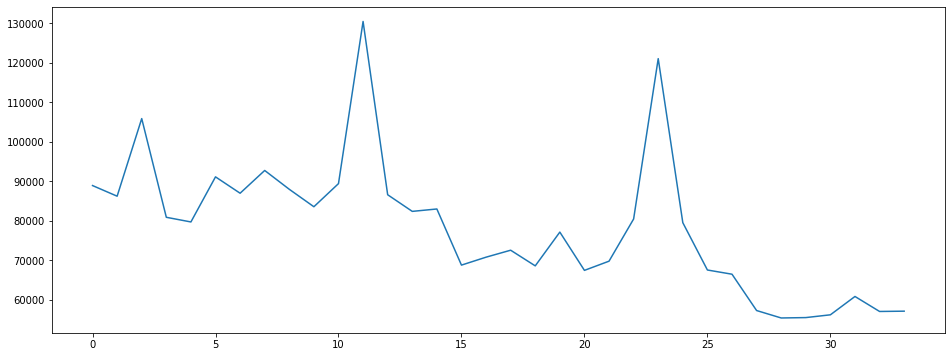

In [235]:
# let's plot the global monthly target again date_block_num
plt.figure(figsize=(16,6))
plt.plot(all_data.groupby('date_block_num').agg({'target':'sum'}))
plt.show()

there is a dicreasing trend over time and we have to peeks correponding to month 11 and 23 which correpond to november (maybe sales before christmas).
So it is relevant to create features month and year from date_block_num in order to capture this trends 

In [236]:
# let's create a month and year columns that we can extract from date_block_num
# month for all data and test sets
all_data['month'] = all_data['date_block_num']%12+1
test['month'] = test['date_block_num']%12+1

# year for all data and test sets
all_data['year'] = all_data['date_block_num']//12+1
test['year'] = test['date_block_num']//12+1


we can also add meanningful features derived from aggregation of target  according to shop_city and general_category

In [237]:
# Target depending on item_id and shop_city_city
gb = all_data.groupby(['date_block_num', 'shop_city_labelencoded', 'item_id'], as_index = False).agg(target_shop_city_item=pd.NamedAgg(column='target',aggfunc='sum'))
all_data = pd.merge(all_data, gb, how = 'left', on = ['date_block_num', 'shop_city_labelencoded', 'item_id'])
all_data['target_shop_city_item'] = all_data['target_shop_city_item'].fillna(0)

In [238]:
# Target depending on shop_id general_category
gb = all_data.groupby(['date_block_num', 'general_category_labelencoded', 'shop_id'], as_index = False).agg(target_general_category_shop=pd.NamedAgg(column='target',aggfunc='sum'))
all_data = pd.merge(all_data, gb, how = 'left', on = ['date_block_num', 'general_category_labelencoded', 'shop_id'])
all_data['target_general_category_shop'] = all_data['target_general_category_shop'].fillna(0)

# Feature engineering

first, let's create a new feature by concatenating shop_id and item_id. this feature should be valuable because it gives information about selling performances for an item in a specific shop

In [239]:
all_data['shop_id-item_id'] = all_data['shop_id'].astype(str)+'-'+all_data['item_id'].astype(str)
test['shop_id-item_id'] = test['shop_id'].astype(str)+'-'+test['item_id'].astype(str)

## Mean encoding

In [240]:
# categorical features to encode
categorical_feat = ['shop_id','item_id','item_category_id','shop_id-item_id','shop_city_labelencoded','location_category_labelencoded','general_category_labelencoded','month','year']

# target columns for encoding the categorical features
target_cols = ['target']

### expanding mean scheme

In [241]:
# encoding according to target, target_shop and target_item
for targ in target_cols:
    global_mean = all_data[targ].mean()
    for cat_feat in categorical_feat:
        cumsum = all_data.groupby(cat_feat)[targ].cumsum()-all_data[targ]
        cumcnt = all_data.groupby(cat_feat)[targ].cumcount()

        all_data[cat_feat+'_'+targ+'_exp_mean_enc'] = cumsum/cumcnt
        all_data[cat_feat+'_'+targ+'_exp_mean_enc'].fillna(all_data[targ].mean(), inplace=True)

        mean = all_data.groupby(cat_feat)[targ].mean()
        test[cat_feat+'_'+targ+'_exp_mean_enc'] = test['shop_id'].map(mean)
        test[cat_feat+'_'+targ+'_exp_mean_enc'].fillna(global_mean, inplace=True)
        
        encoded_feature = all_data[cat_feat+'_'+targ+'_exp_mean_enc'].values
        corr = np.corrcoef(all_data[targ].values, encoded_feature)[0][1]
        print(f'correlation between {cat_feat+"_"+targ+"_exp_mean_enc"} and {targ}: ',corr)
        
del cumsum , cumcnt , encoded_feature, corr 
gc.collect();

correlation between shop_id_target_exp_mean_enc and target:  0.17877969939069735
correlation between item_id_target_exp_mean_enc and target:  0.5690545485373696
correlation between item_category_id_target_exp_mean_enc and target:  0.29629923847745104
correlation between shop_id-item_id_target_exp_mean_enc and target:  0.5420962943370419
correlation between shop_city_labelencoded_target_exp_mean_enc and target:  0.12333610965451257
correlation between location_category_labelencoded_target_exp_mean_enc and target:  0.040591187052152866
correlation between general_category_labelencoded_target_exp_mean_enc and target:  0.17931419989503083
correlation between month_target_exp_mean_enc and target:  0.06967532638624017
correlation between year_target_exp_mean_enc and target:  0.019905881569833236


we can also use lags from [1, 2, 3] months ago.

In [242]:
# first we need to concatenate all_data with test in order to lag easily for date_block_num 34
all_data = pd.concat([all_data,test]).fillna(0)

In [243]:
print(all_data.shape)
all_data.head()

(8799229, 28)


,shop_id,item_id,date_block_num,target,num_monthly_sales,average_price,target_shop,target_item,blocks_since_first,is_new,item_category_id,general_category_labelencoded,shop_city_labelencoded,location_category_labelencoded,month,year,target_shop_city_item,target_general_category_shop,shop_id-item_id,shop_id_target_exp_mean_enc,item_id_target_exp_mean_enc,item_category_id_target_exp_mean_enc,shop_id-item_id_target_exp_mean_enc,shop_city_labelencoded_target_exp_mean_enc,location_category_labelencoded_target_exp_mean_enc,general_category_labelencoded_target_exp_mean_enc,month_target_exp_mean_enc,year_target_exp_mean_enc
0,59,22154,0,1.0,1.0,999.0,2017.0,16.0,0.0,1,37,11,28,2,1,1,1.0,559.0,59-22154,0.310531,0.310531,0.310531,0.310531,0.310531,0.310531,0.310531,0.310531,0.310531
1,59,2552,0,0.0,0.0,0.0,2017.0,0.0,0.0,1,58,13,28,2,1,1,0.0,174.0,59-2552,1.000000,0.310531,0.310531,0.310531,1.000000,1.000000,0.310531,1.000000,1.000000
2,59,2554,0,0.0,0.0,0.0,2017.0,1.0,0.0,1,58,13,28,2,1,1,0.0,174.0,59-2554,0.500000,0.310531,0.000000,0.310531,0.500000,0.500000,0.000000,0.500000,0.500000
3,59,2555,0,0.0,0.0,0.0,2017.0,1.0,0.0,1,56,13,28,2,1,1,0.0,174.0,59-2555,0.333333,0.310531,0.310531,0.310531,0.333333,0.333333,0.000000,0.333333,0.333333
4,59,2564,0,0.0,0.0,0.0,2017.0,4.0,0.0,1,59,13,28,2,1,1,0.0,174.0,59-2564,0.250000,0.310531,0.310531,0.310531,0.250000,0.250000,0.000000,0.250000,0.250000


In [244]:
index_cols_2 = ['shop_id', 'item_id', 'item_category_id' , 'date_block_num']
# we are going to create lags on the following columns
feats_to_lag = ['target','num_monthly_sales','average_price','target_shop','target_item','target_shop_city_item','target_general_category_shop']
# let's set different months shift ranges we want to introduce 
shift_range = [1, 2, 3]

for month_shift in tqdm_notebook(shift_range):
    train_shift = all_data[index_cols_2 + feats_to_lag].copy()
    
    train_shift['date_block_num'] = train_shift['date_block_num'] + month_shift
    
    foo = lambda x: '{}_lag_{}'.format(x, month_shift) if x in feats_to_lag else x
    train_shift = train_shift.rename(columns=foo)

    all_data = pd.merge(all_data, train_shift, on=index_cols_2, how='left').fillna(0)

del train_shift
   

# Don't use old data from date_block_num < 3
all_data = all_data[all_data['date_block_num'] >= 3] 


gc.collect();

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


In [245]:
all_data.head()

,shop_id,item_id,date_block_num,target,num_monthly_sales,average_price,target_shop,target_item,blocks_since_first,is_new,item_category_id,general_category_labelencoded,shop_city_labelencoded,location_category_labelencoded,month,year,target_shop_city_item,target_general_category_shop,shop_id-item_id,shop_id_target_exp_mean_enc,item_id_target_exp_mean_enc,item_category_id_target_exp_mean_enc,shop_id-item_id_target_exp_mean_enc,shop_city_labelencoded_target_exp_mean_enc,location_category_labelencoded_target_exp_mean_enc,general_category_labelencoded_target_exp_mean_enc,month_target_exp_mean_enc,year_target_exp_mean_enc,target_lag_1,num_monthly_sales_lag_1,average_price_lag_1,target_shop_lag_1,target_item_lag_1,target_shop_city_item_lag_1,target_general_category_shop_lag_1,target_lag_2,num_monthly_sales_lag_2,average_price_lag_2,target_shop_lag_2,target_item_lag_2,target_shop_city_item_lag_2,target_general_category_shop_lag_2,target_lag_3,num_monthly_sales_lag_3,average_price_lag_3,target_shop_lag_3,target_item_lag_3,target_shop_city_item_lag_3,target_general_category_shop_lag_3
784711,25,8092,3,3.0,3.0,149.0,7867.0,20.0,3.0,0,40,11,12,0,4,1,6.0,2790.0,25-8092,1.029819,0.854369,0.282266,1.666667,0.598345,0.397575,0.264814,0.310531,0.358151,1.0,1.0,149.0,9732.0,24.0,7.0,3220.0,0.0,0.0,0.0,7934.0,18.0,5.0,2683.0,4.0,4.0,149.0,8215.0,46.0,15.0,3007.0
784712,25,7850,3,3.0,3.0,199.0,7867.0,59.0,3.0,0,30,8,12,0,4,1,15.0,984.0,25-7850,1.029905,2.029126,1.233800,4.000000,0.598360,0.397588,1.303467,3.000000,0.358154,5.0,4.0,199.0,9732.0,72.0,26.0,1245.0,1.0,1.0,199.0,7934.0,39.0,9.0,985.0,6.0,5.0,199.0,8215.0,98.0,16.0,1073.0
784713,25,8051,3,3.0,2.0,30.0,7867.0,5.0,3.0,0,66,14,12,0,4,1,3.0,1032.0,25-8051,1.029991,0.058252,0.205279,0.000000,0.598375,0.397602,0.315142,3.000000,0.358158,0.0,0.0,0.0,9732.0,1.0,0.0,1030.0,0.0,0.0,0.0,7934.0,2.0,1.0,935.0,0.0,0.0,0.0,8215.0,3.0,3.0,874.0
784714,25,8088,3,1.0,1.0,199.0,7867.0,2.0,3.0,0,55,13,12,0,4,1,1.0,1130.0,25-8088,1.030077,0.067961,0.208362,0.666667,0.598390,0.397616,0.168631,3.000000,0.358161,1.0,1.0,199.0,9732.0,4.0,2.0,1137.0,1.0,1.0,199.0,7934.0,1.0,1.0,1135.0,0.0,0.0,0.0,8215.0,2.0,0.0,1097.0
784715,25,8089,3,1.0,1.0,199.0,7867.0,14.0,3.0,0,55,13,12,0,4,1,2.0,1130.0,25-8089,1.030076,0.281553,0.208368,0.333333,0.598392,0.397619,0.168635,2.500000,0.358162,0.0,0.0,0.0,9732.0,13.0,4.0,1137.0,1.0,1.0,199.0,7934.0,10.0,2.0,1135.0,0.0,0.0,0.0,8215.0,6.0,0.0,1097.0


### lagged features interaction

In [246]:
# difference between target_lag_1 and target_lag_2
all_data['diff_target_lag_1_lag_2'] = all_data['target_lag_1']-all_data['target_lag_2']

# increase between target_lag_1 and target_lag_2
all_data['inc_target_lag_1_lag_2'] = (all_data['target_lag_1']-all_data['target_lag_2'])/all_data['target_lag_2']
all_data['inc_target_lag_1_lag_2'] = all_data['inc_target_lag_1_lag_2'].replace([np.inf], np.nan).fillna(0)

# target_lag_mean
all_data['target_lag_average'] = all_data[['target_lag_1','target_lag_2','target_lag_3']].mean(axis=1)

## feature extraction (after processing feature extraction from text vectorization there is a lack of RAM while training models)
I will just let the code here even if I didn't use it

now that we have created lagged features from target, target_shop and target_item we can vectorize text from item name, category name and shop name that can be very valuable for our purpose

In [ ]:
# Installing nltk package in the current Jupyter kernel
#import sys
#!{sys.executable} -m pip install nltk

In [ ]:
# installing pymystem3 v3.0 (had some troubles with latest version, please take a look at https://github.com/nlpub/pymystem3/issues/28)
#!wget http://download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz
#!tar -xvf mystem-3.0-linux3.1-64bit.tar.gz
#!cp mystem /bin

In [ ]:
#import nltk
#from pymystem3 import Mystem
#from nltk.corpus import stopwords 
#nltk.download('stopwords')


#mystem = Mystem() 
#russian_stopwords = stopwords.words("russian")
#from string import punctuation

#Preprocess function
#def my_tokenizer(text):
    #tokens = mystem.lemmatize(text.lower())
    #tokens = [token for token in tokens if token not in russian_stopwords\
              #and token != " " \
              #and token.strip() not in punctuation]
    
    #return tokens

In [ ]:
#vectorizer = TfidfVectorizer(max_features = 10 , tokenizer=my_tokenizer)

In [ ]:
#####tokenizing item_name#####
#X = vectorizer.fit_transform(items['item_name'])
# transforming X to a DataFrame
#X_df = pd.DataFrame(X.toarray())
#X_df['item_id']=items['item_id']
# now we can merge X_df and all_data on item_id
#all_data = pd.merge(all_data,X_df,on='item_id',how='left')
#all_data = downcast_dtypes(all_data)

#del X,X_df
#gc.collect();

In [ ]:
#####tokenizing shop_name#####
#X = vectorizer.fit_transform(shops['shop_name'])
# transforming X to a DataFrame
#X_df = pd.DataFrame(X.toarray())
#X_df['shop_id']=shops['shop_id']
# now we can merge X_df and all_data on shop_id
#all_data = pd.merge(all_data,X_df,on='shop_id',how='left')
#all_data = downcast_dtypes(all_data)

#del X,X_df
#gc.collect();

In [ ]:
#####tokenizing item_category_name#####
#X = vectorizer.fit_transform(item_cats['item_category_name'])
# transforming X to a DataFrame
#X_df = pd.DataFrame(X.toarray())
#X_df['item_category_id']=item_cats['item_category_id']
# now we can merge X_df and all_data on item_category_id
#all_data = pd.merge(all_data,X_df,on='item_category_id',how='left')
#all_data = downcast_dtypes(all_data)

#del X,X_df
#gc.collect();

In [ ]:
all_data = downcast_dtypes(all_data)
print('data shape: ',all_data.shape)
all_data.isna().sum()

data shape:  (9988310, 50)


shop_id                                               0
item_id                                               0
date_block_num                                        0
target                                                0
num_monthly_sales                                     0
average_price                                         0
target_shop                                           0
target_item                                           0
item_category_id                                      0
general_category_labelencoded                         0
shop_city_labelencoded                                0
location_category_labelencoded                        0
month                                                 0
year                                                  0
target_shop_city_item                                 0
target_general_category_shop                          0
shop_id-item_id                                       0
shop_id_target_exp_mean_enc                     

first we need  to set our train, validation and test sets. For train set we take all the recordings corresponding to months 0 to 32
for validation set we take all the recordings from month 33
and for test set we take all the recordings from month 34

In [ ]:
# save data in order to reload it if needed
all_data.to_pickle('all_data.pkl')

In [247]:
# features to drop
feats_to_drop = feats_to_lag + ['shop_id-item_id']
feats_to_drop

['target',
 'num_monthly_sales',
 'average_price',
 'target_shop',
 'target_item',
 'target_shop_city_item',
 'target_general_category_shop',
 'shop_id-item_id']

In [248]:
# train set
X_train = all_data[all_data['date_block_num']<33].drop(feats_to_drop,axis=1)
y_train = all_data[all_data['date_block_num']<33]['target']
print('X_train shape: ',X_train.shape)
print('y_train shape: ',y_train.shape)

X_train shape:  (7578516, 44)
y_train shape:  (7578516,)


In [249]:
# validation set
X_val = all_data[all_data['date_block_num']==33].drop(feats_to_drop,axis=1)
y_val = all_data[all_data['date_block_num']==33]['target']
print('X_val shape: ',X_val.shape)
print('y_val shape: ',y_val.shape)

X_val shape:  (221802, 44)
y_val shape:  (221802,)


In [250]:
# test set
X_test = all_data[all_data['date_block_num']==34].drop(feats_to_drop,axis=1)
print('X_test shape: ',X_test.shape)

X_test shape:  (214200, 44)


In [251]:
del all_data
gc.collect()

466

# Ensembling

In [252]:
from xgboost import XGBRegressor
from xgboost import plot_importance

def plot_features(booster , features):
    fig , ax = plt.subplots(1,1,figsize = (16,10))
    return plot_importance(booster = booster , ax = ax)

import time

In [253]:
#implementing xgboost ~

ts = time.time()

model = XGBRegressor(
    max_depth=8,
    n_estimators=200,
    min_child_weight=300, 
    colsample_bytree=0.75, 
    subsample=0.75, 
    eta=0.3,    
    random_state=42,
    n_jobs=-1)

model.fit(
    X_train, 
    y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, y_train), (X_val, y_val)], 
    verbose=True, 
    early_stopping_rounds = 10)

time.time() - ts

[21:17:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:17:48] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-rmse:1.1903	validation_1-rmse:1.0563
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.14404	validation_1-rmse:1.01791
[2]	validation_0-rmse:1.10487	validation_1-rmse:0.986307
[3]	validation_0-rmse:1.06905	validation_1-rmse:0.955958
[4]	validation_0-rmse:1.02687	validation_1-rmse:0.918536
[5]	validation_0-rmse:0.990963	validation_1-rmse:0.886711
[6]	validation_0-rmse:0.960883	validation_1-rmse:0.859632
[7]	validation_0-rmse:0.935202	validation_1-rmse:0.840324
[8]	validation_0-rmse:0.913448	validation_1-r

2380.432209253311

In [254]:
# submission file~

XGB_pred = model.predict(X_test).clip(0,20)

submission = pd.DataFrame({"ID": test_ID, "item_cnt_month": XGB_pred})
submission.to_csv('submission_v1.4.1.csv', index=False)

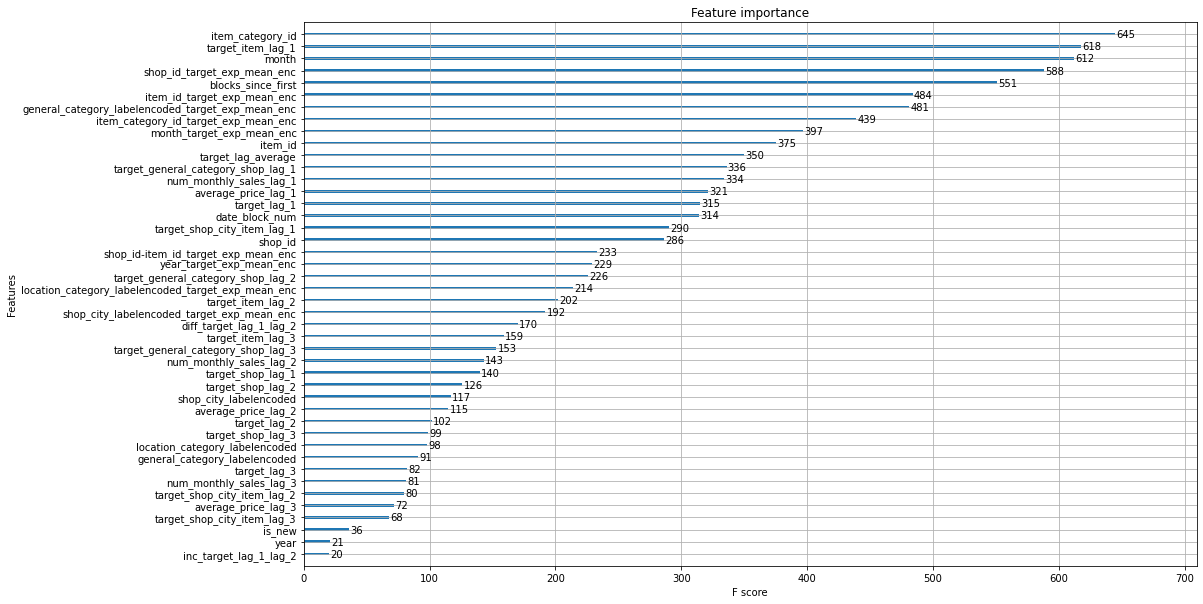

In [255]:
# feature importance
plot_features(model , X_train.columns)